# Pairs Selection

### This notebook is the implementation part for Chapter 1. 

The workflow in this notebook is roughly:

1. Load data
2. Apply PCA to reduce dimensions of data and normalize principal compoinents using a Scaler
3. Fit data into OPTICS, a clustering algorithm
4. Compute cluster assignments & possible number of pairs
5. Visualize clusters (2D & 3D) using tSNE
6. Apply statistical criteria to filter out pairs, namely cointegration tests, checking the Hurst exponent for spreads, checking the half-life of spreads and checking the number of times the spread crosses its mean

In [1]:
# Imports, read and preview data

import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
import numpy as np
from sklearn.manifold import TSNE
from collections import defaultdict
from itertools import combinations
import json
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
from statsmodels.regression.linear_model import OLS

with open('../../data/ch0_etfs.pkl', 'rb') as f:
    df, df_returns = pickle.load(f)

### The purpose of PCA

In our current dataset, we have ~1000 data points per ticker. This makes it difficult to cluster these assets based on their features, therefore we would like a representation of the price series of each ticker with less dimensions. This approach also loosely represents the decomposition of risk factors of price series in theoretical finance. Further explanation about the relationship between dimensionality reduction and risk factors can be found in the thesis itself.

Existing literature proposes that 5 principal components are a decent choice in terms of explained variance and addition of further principal components has marginally low benefits after that point (Sarmento, 2019). More dimensions will result in more explained variance for PCA but will cripple our efforts of clustering.

In [2]:
# Apply PCA to returns data

pca = PCA(n_components=5, svd_solver='auto', random_state=42)
pca.fit(df_returns)
explained_variance = pca.explained_variance_ratio_

for i in range(len(explained_variance)):
    print(f"Variance explained by PC{i+1}: {explained_variance[i]:.2%}")

Variance explained by PC1: 66.43%
Variance explained by PC2: 8.30%
Variance explained by PC3: 3.17%
Variance explained by PC4: 2.50%
Variance explained by PC5: 2.06%


Principal components can have varying magnitudes which will skew the results of our clustering algorithm, therefore we normalize the principal components using a standard scaler.

Means of PCs after scaling: [-0.05324484  0.00837298  0.0103851  -0.01149689 -0.01657708]


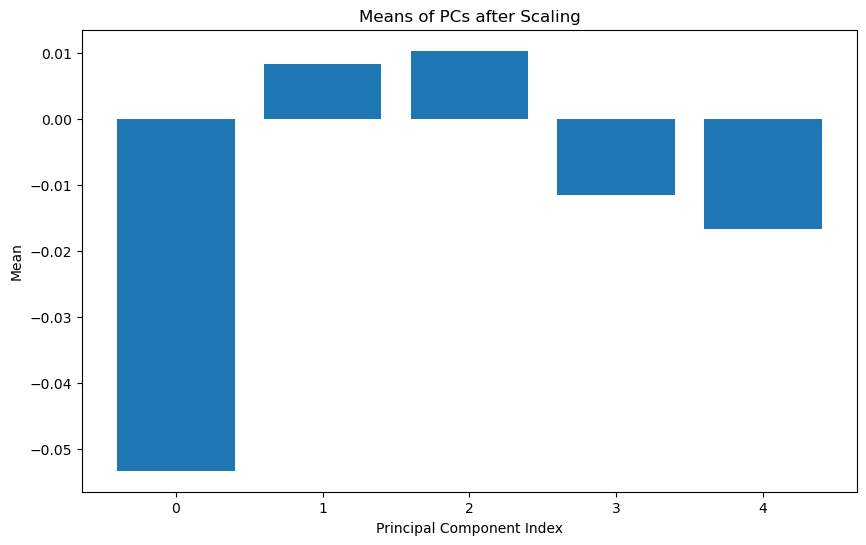

Standard deviations of PCs after scaling: [0.04287056 0.06784387 0.06756513 0.06738485 0.06631816]


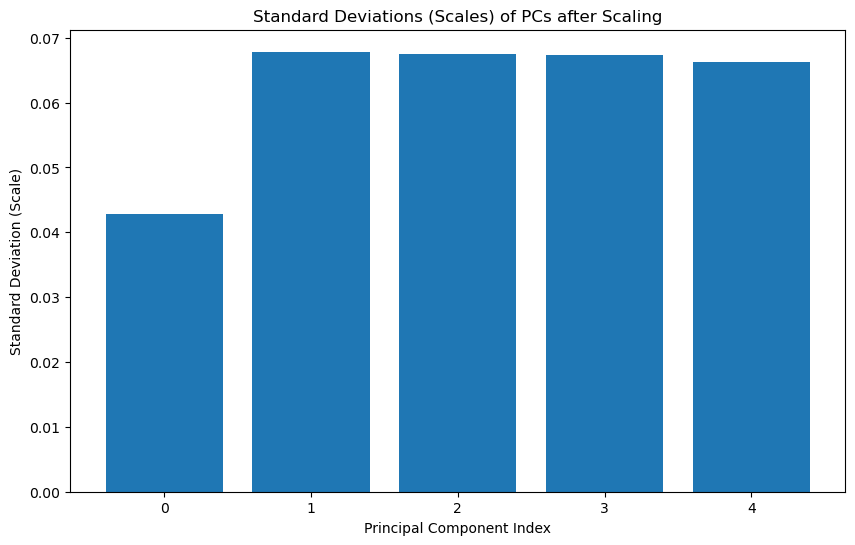

In [3]:
# Normalize PCA components using Standard Scaler

scaler = StandardScaler()
X = scaler.fit_transform(pca.components_.T)
print(f"Means of PCs after scaling: {scaler.mean_}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(scaler.mean_)), scaler.mean_)
plt.title('Means of PCs after Scaling')
plt.xlabel('Principal Component Index')
plt.ylabel('Mean')
plt.savefig('../../assets/etfs/means_of_pcs_after_scaling.png')
plt.show()

print(f"Standard deviations of PCs after scaling: {scaler.scale_}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(scaler.scale_)), scaler.scale_)
plt.title('Standard Deviations (Scales) of PCs after Scaling')
plt.xlabel('Principal Component Index')
plt.ylabel('Standard Deviation (Scale)')
plt.savefig('../../assets/etfs/standard_deviations_of_pcs_after_scaling.png')
plt.show()

## Clustering

### Why OPTICS?

The most common clustering algorithms assume gaussian distributions along the cluster members (which is a strong assumption about our data we're not yet ready to make), are not well choices for handling outliers or noisy data (which we assume we have because of the nature of financial data), require number of clusters or cluster definitions to be specified beforehand (which we don't know) or require intervention of the developer/trader/investor through a termination criterion which might cause unnecessary bias in a trading scenario (which we're trying to avoid altogether with the ML approach throughout this whole experiment). Based on these requirements, we can eliminate all partition-based clustering algorithms (e.g. k-means) and hierarchical clustering algorithms.

Based on the above criteria, density-based algorithms seem like a good fit. The most popular algorithm in this group is DBSCAN, but DBSCAN requires the developer to specify the number of clusters and the radius of the cluster beforehand. That leads us to the choice of OPTICS, which relies on a more flexible (and more compute heavy) approach where the algorithm itself decides on the number of clusters and the radius of the cluster based on a single parameter by the developer, the minimum number of members in the cluster. This deems the algorithm **almost** parameterless. OPTICS also does a good job of classifying outliers (or members not assigned to any cluster), which plays well into our pairs trading framework: It helps us filter out ETFs with no cluster meaning no similarity in price trends with any other members in the group.

We proceed by fitting the results of our PCA into OPTICS. We inspect the number of clusters, number of ETFs assigned to a cluster and the number of possible pair combinations to evaluate in the following section. We also visualize the results of the clustering algorithm using 2D and 3D t-SNE.

In [4]:
# Cluster PCs of returns using OPTICS

optics = OPTICS(min_samples=3, max_eps=5, xi=0.05, metric='euclidean', cluster_method='xi')
optics.fit(X)
labels = optics.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters after OPTICS (excluding outliers): %d" % n_clusters_)

Number of clusters after OPTICS (excluding outliers): 22


In [5]:
# Assign clusters to ETFs

clustered_series_all = pd.Series(index=df_returns.columns, data=labels.flatten())
clustered_series = clustered_series_all[clustered_series_all != -1]

print(f"Number of ETFs assigned to a cluster: {len(clustered_series)}")

Number of ETFs assigned to a cluster: 90


In [6]:
# Compute cluster counts and pairs to evaluate

counts = clustered_series.value_counts()
counts.sort_index(inplace=True)
for i in counts.index:
    print(f"Cluster {i}: {counts[i]} ETFs")

print('Average cluster size: ', np.mean(counts))
print("Pairs to evaluate: %d" % (counts * (counts - 1) / 2).sum())

Cluster 0: 3 ETFs
Cluster 1: 3 ETFs
Cluster 2: 5 ETFs
Cluster 3: 3 ETFs
Cluster 4: 3 ETFs
Cluster 5: 5 ETFs
Cluster 6: 4 ETFs
Cluster 7: 5 ETFs
Cluster 8: 4 ETFs
Cluster 9: 7 ETFs
Cluster 10: 4 ETFs
Cluster 11: 3 ETFs
Cluster 12: 3 ETFs
Cluster 13: 4 ETFs
Cluster 14: 3 ETFs
Cluster 15: 7 ETFs
Cluster 16: 4 ETFs
Cluster 17: 3 ETFs
Cluster 18: 7 ETFs
Cluster 19: 3 ETFs
Cluster 20: 3 ETFs
Cluster 21: 4 ETFs
Average cluster size:  4.090909090909091
Pairs to evaluate: 159


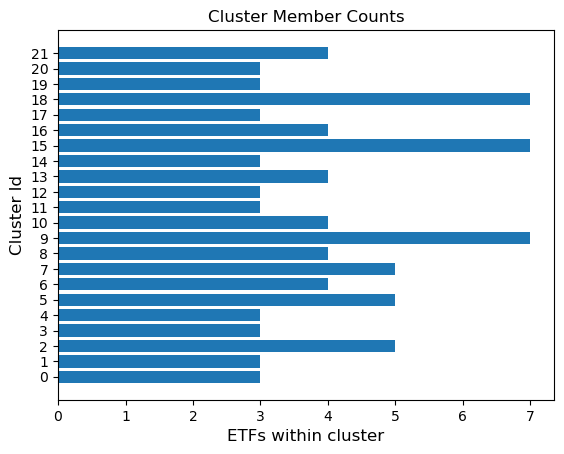

In [7]:
# Visualize cluster counts

plt.figure()
plt.barh(counts.index, counts.values)
plt.title('Cluster Member Counts')
plt.yticks(np.arange(0, len(counts), 1))
plt.xlabel('ETFs within cluster', size=12)
plt.ylabel('Cluster Id', size=12)
plt.savefig('../../assets/etfs/cluster_member_counts.png')
plt.show()

In [8]:
# Fit scaled PCs to 2d t-SNE for visualization

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

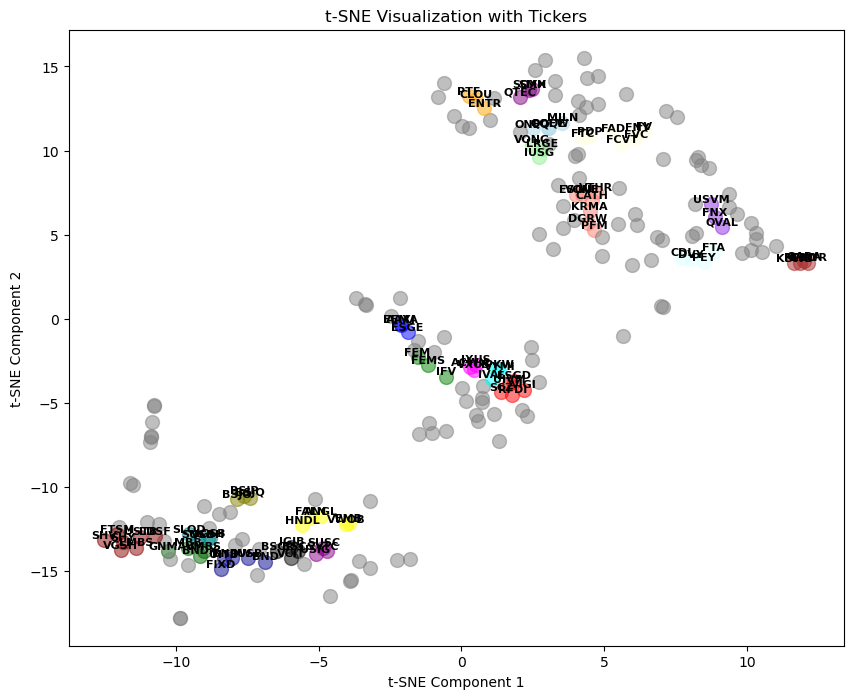

In [9]:
# Plot 2d t-SNE visualization with cluster labels

plt.figure(figsize=(10, 8))

colors = ['gray', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 
               'darkblue', 'darkgreen', 'darkred', 
               'darkcyan', 'darkmagenta', 'olive',
               'lightblue', 'lightgreen', 'salmon', 'lightcyan', 
               'blueviolet', 'lightyellow', 
               'orange', 'purple', 'brown']
for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i, 0], X_tsne[i, 1], color=colors[labels[i] + 1], alpha=0.5, s=100)
    if labels[i] == -1:
        continue
    plt.text(X_tsne[i, 0], X_tsne[i, 1], df_returns.columns[i], fontsize=8, fontweight='bold', horizontalalignment='center', verticalalignment='bottom')
plt.title('t-SNE Visualization with Tickers')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.savefig('../../assets/etfs/tsne_clusters_2d.png')
plt.show()

In [10]:
# Fit scaled PCs to 3d t-SNE for visualization

tsne = TSNE(n_components=3, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

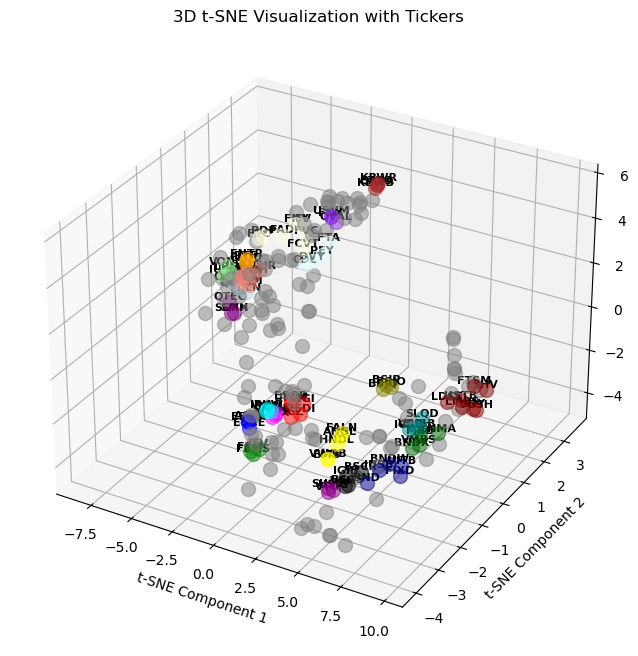

In [11]:
# Plot 3d t-SNE visualization with cluster labels

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['gray', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 
               'darkblue', 'darkgreen', 'darkred', 
               'darkcyan', 'darkmagenta', 'olive',
               'lightblue', 'lightgreen', 'salmon', 'lightcyan', 
               'blueviolet', 'lightyellow', 
               'orange', 'purple', 'brown']
for i in range(len(X_tsne)):
    ax.scatter(X_tsne[i, 0], X_tsne[i, 1], X_tsne[i, 2], color=colors[labels[i] + 1], alpha=0.5, s=100)
    if labels[i] == -1:
        continue
    ax.text(X_tsne[i, 0], X_tsne[i, 1], X_tsne[i, 2], df_returns.columns[i], fontsize=8, fontweight='bold', horizontalalignment='center', verticalalignment='bottom')
ax.set_title('3D t-SNE Visualization with Tickers')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.savefig('../../assets/etfs/tsne_clusters_3d.png')
plt.show()

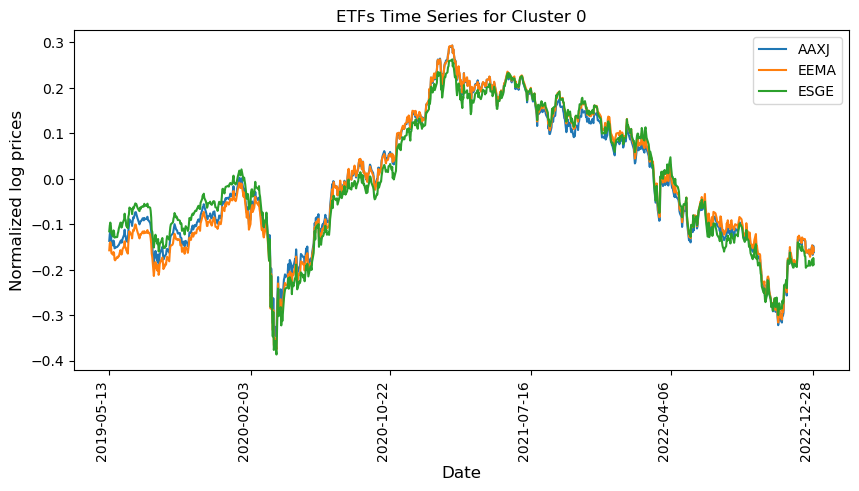

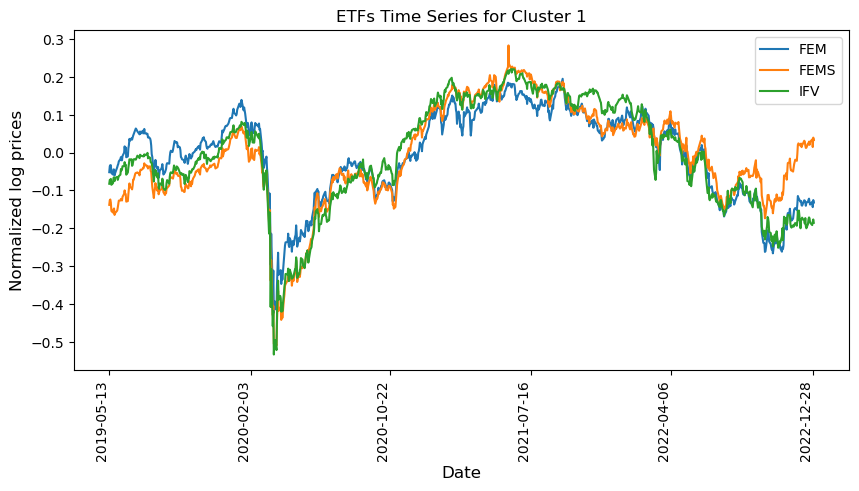

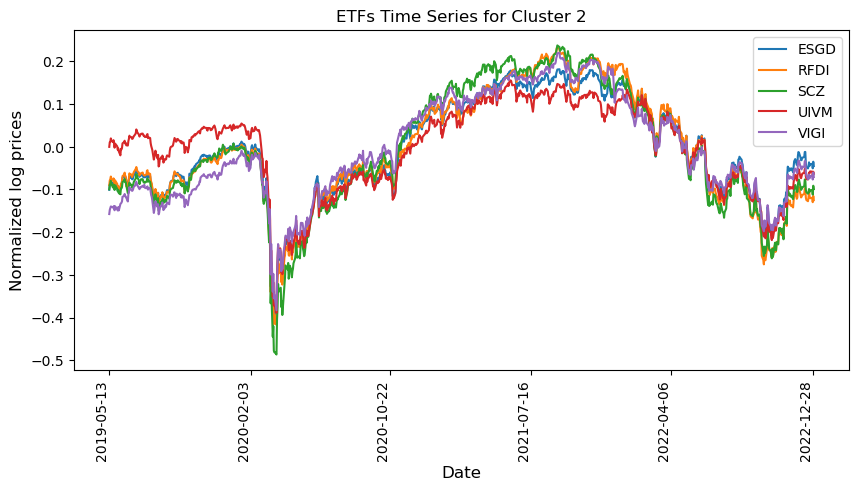

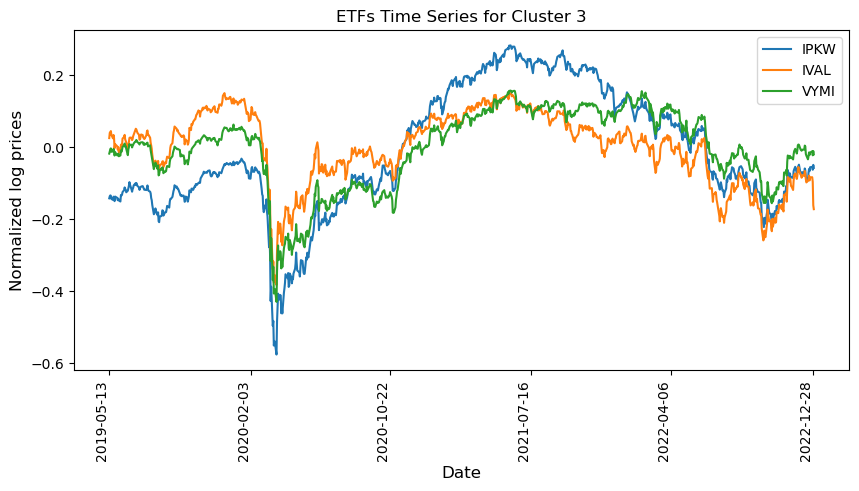

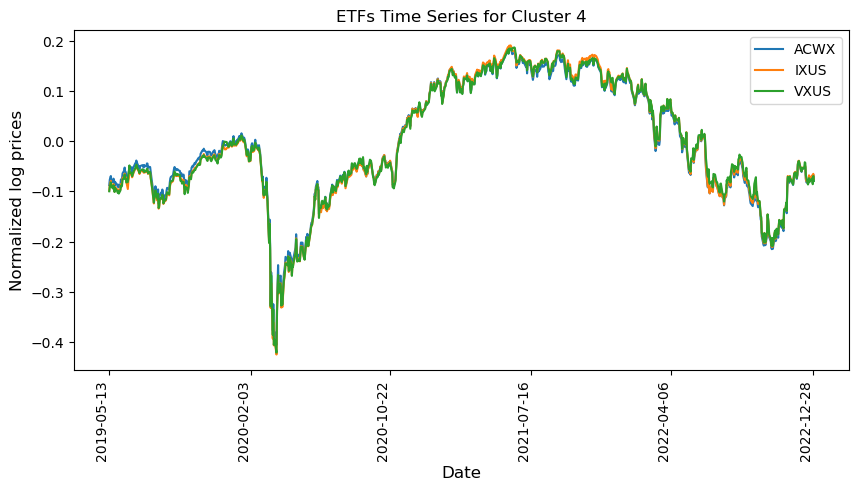

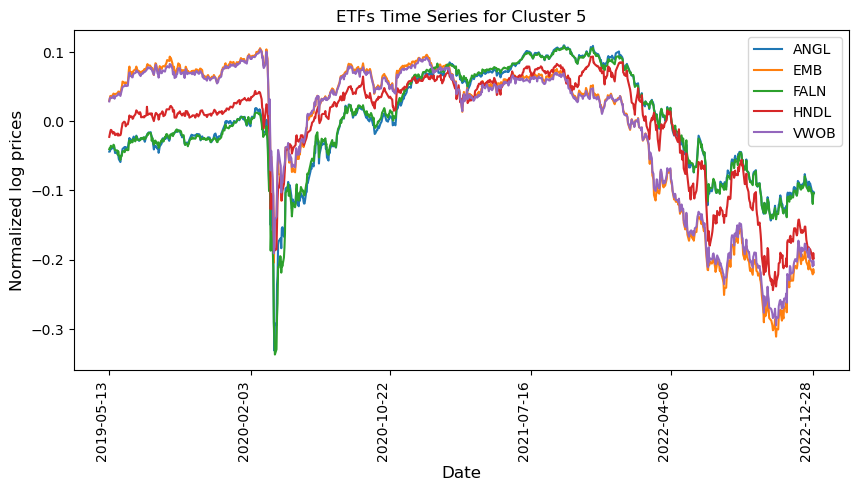

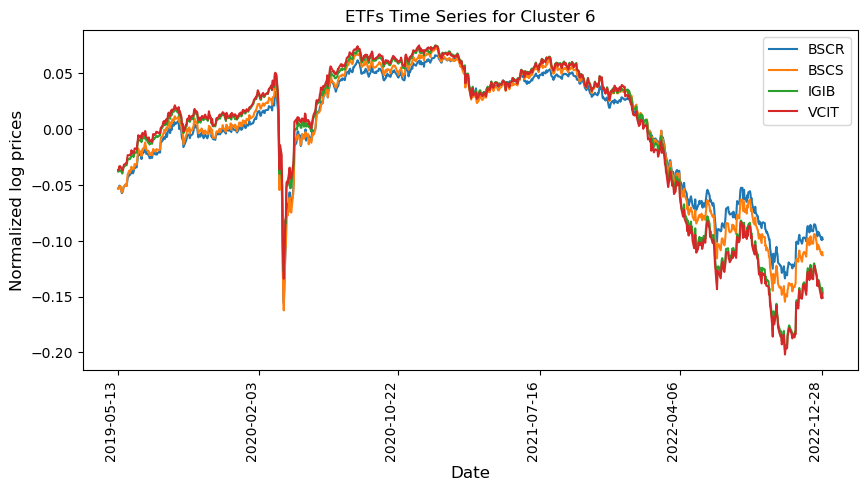

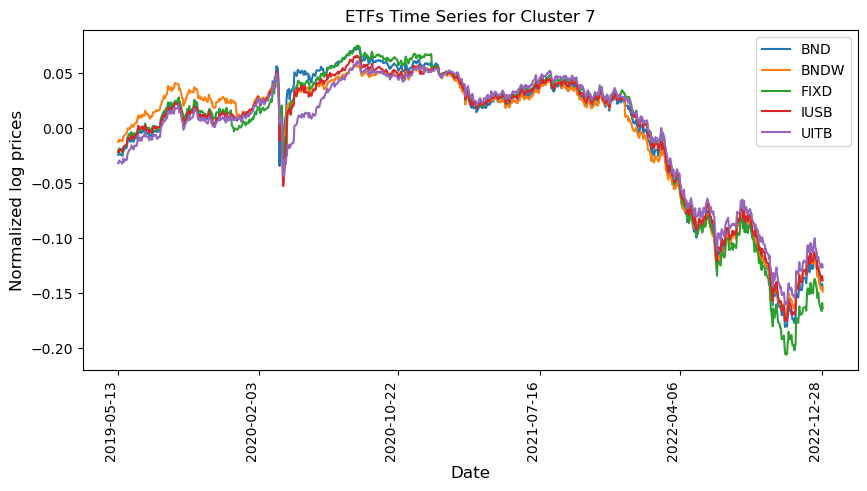

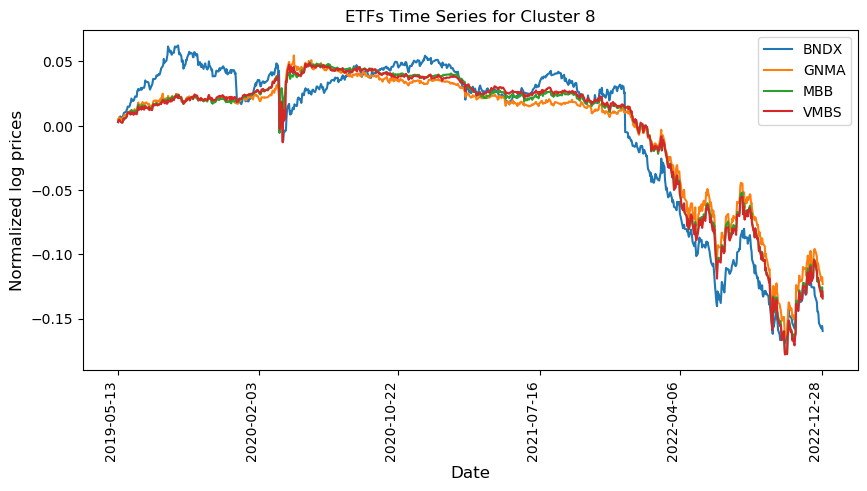

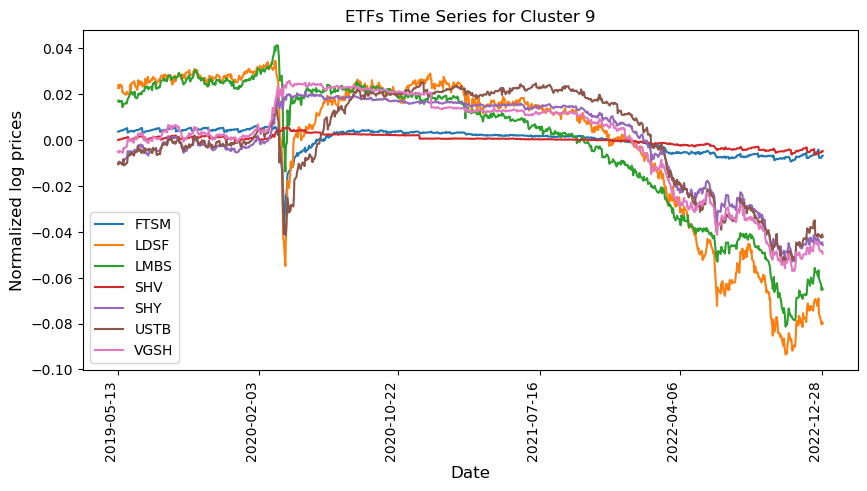

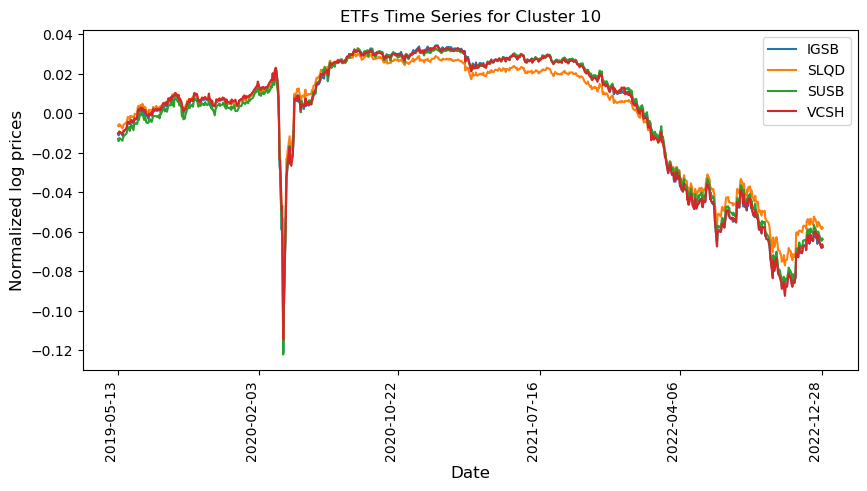

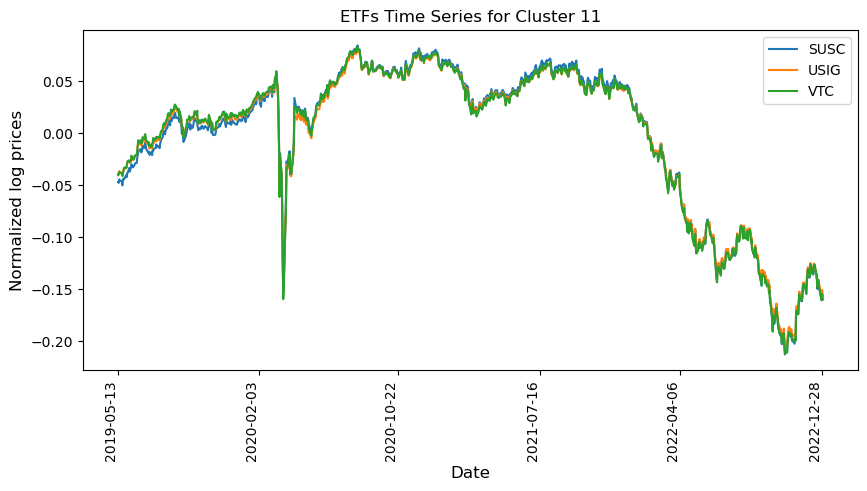

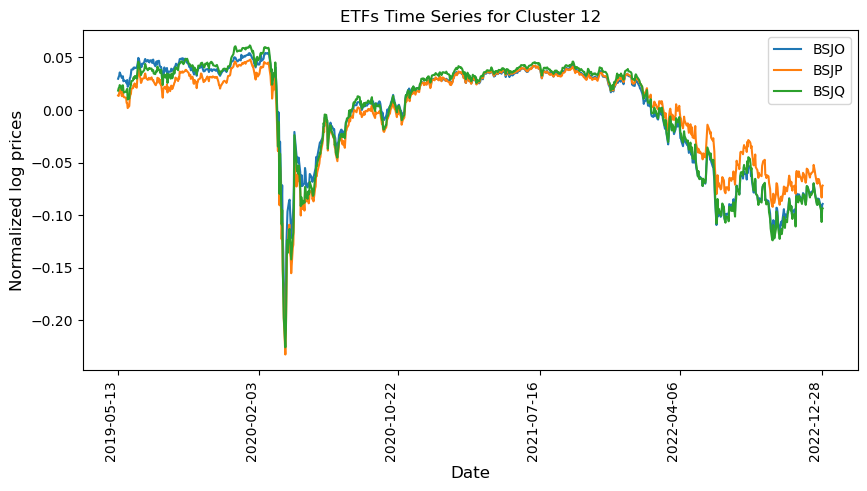

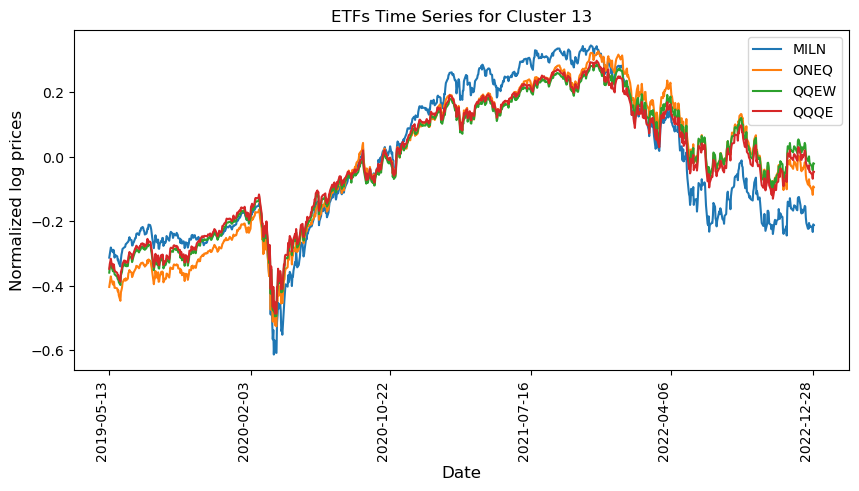

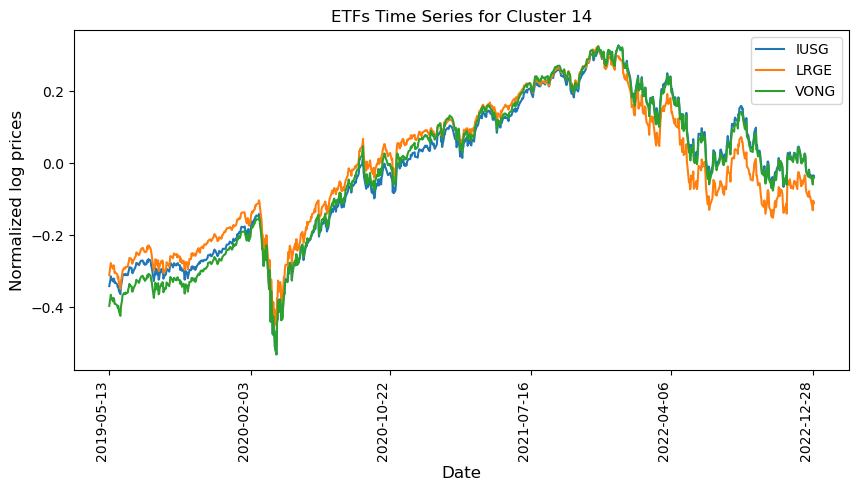

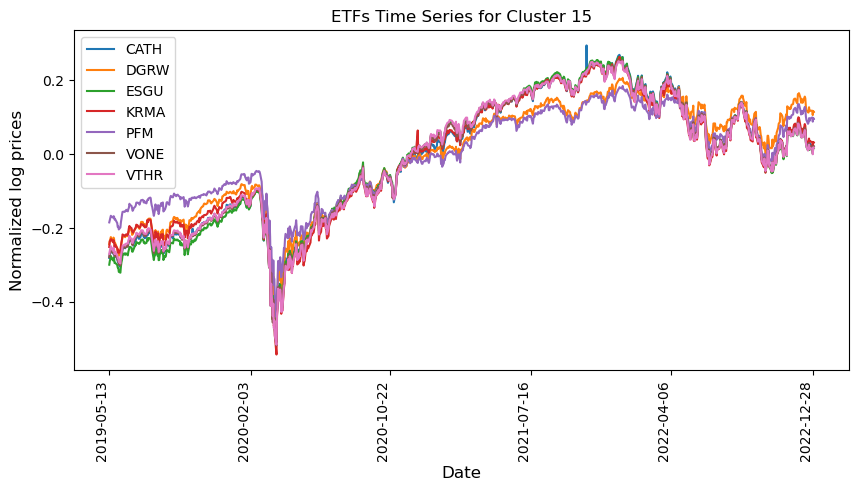

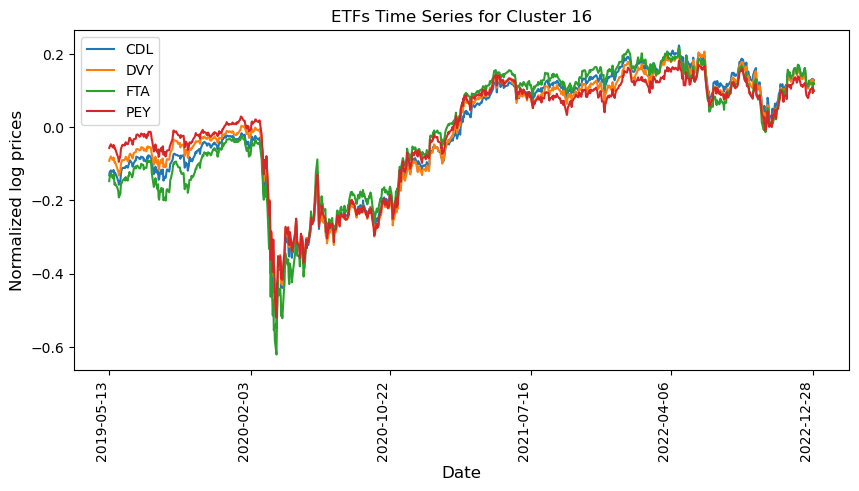

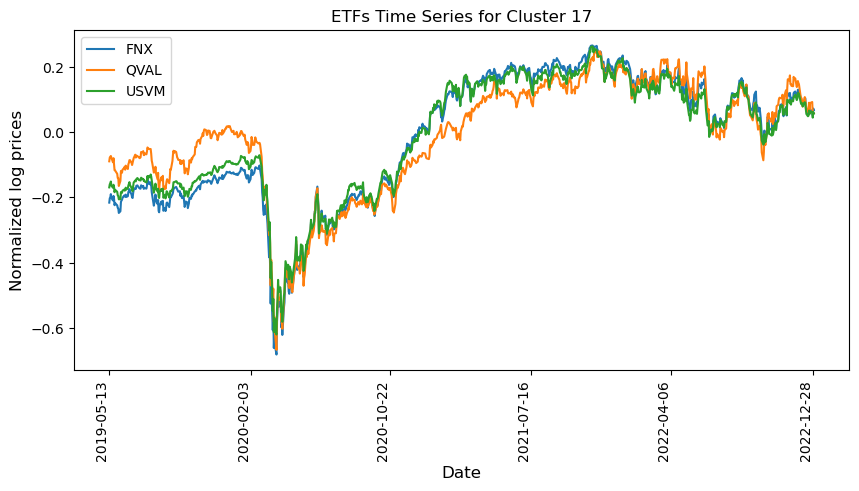

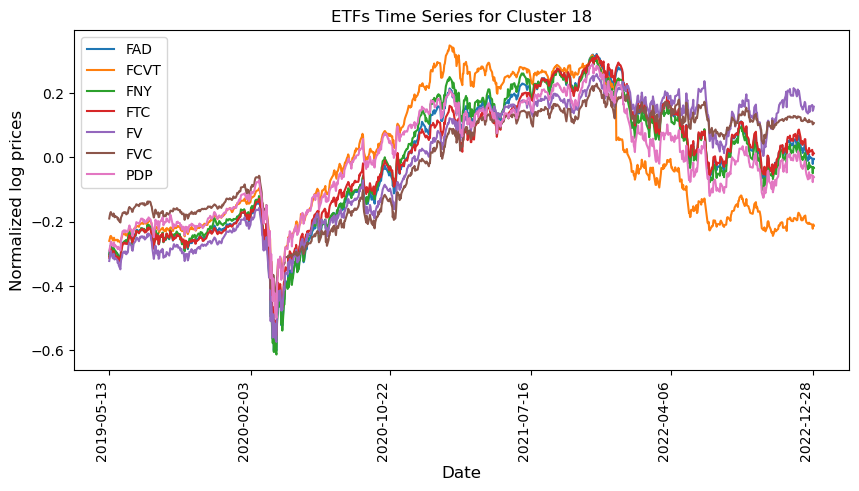

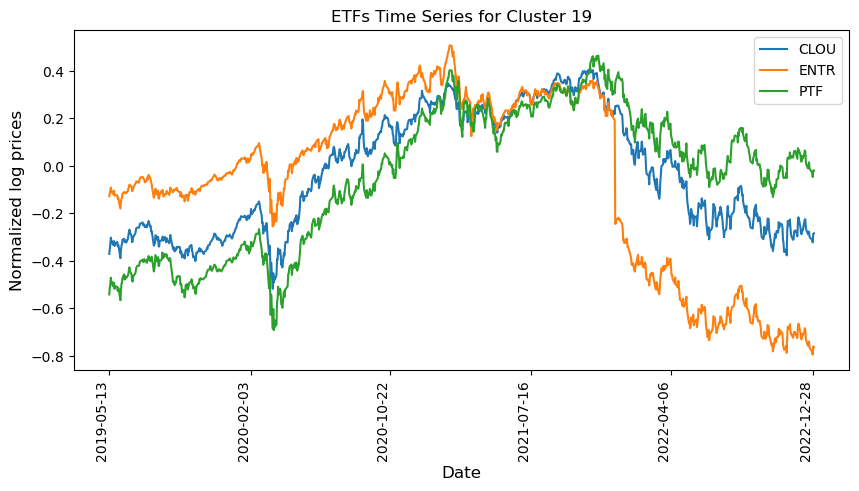

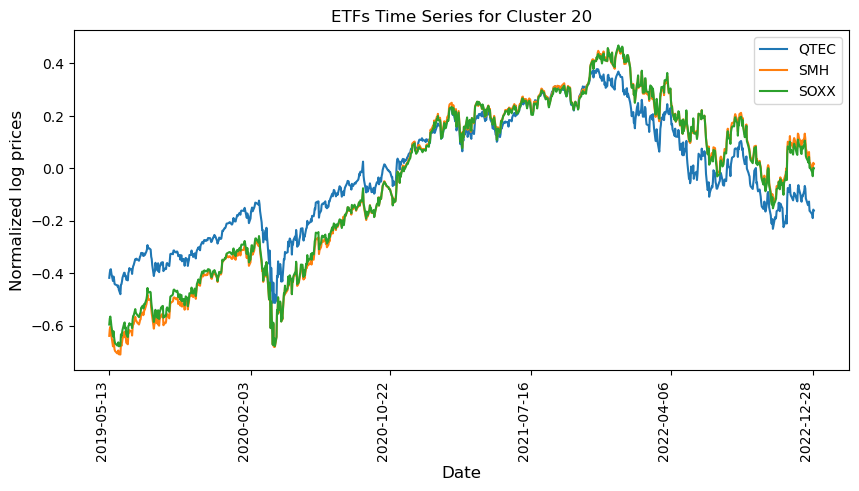

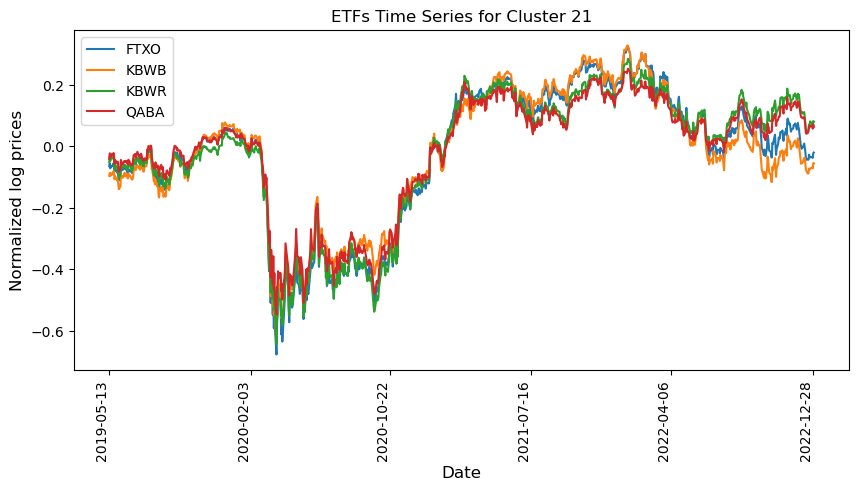

In [12]:
# Visualize price series for all clusters

df.index = pd.to_datetime(df.index)

for cluster in range(len(counts)):
    symbols = list(clustered_series[clustered_series==cluster].index)
    means = np.log(df[symbols].mean())
    series = np.log(df[symbols]).sub(means)
    series.plot(figsize=(10,5), title='ETFs Time Series for Cluster %d' % (cluster))
    plt.ylabel('Normalized log prices', size=12)
    plt.xlabel('Date', size=12)
    num_ticks = 5
    plt.xticks(df.index[::len(df.index)//num_ticks])
    plt.xticks(rotation=90, ha='right')
    plt.savefig(f'../../assets/etfs/cluster_{cluster}_price_graph.png')
    plt.show()

### Prep for Criteria Evaluation

The last step in choosing pairs is filtering them through a sequence of statistical criteria. To achieve that, we need to compile all pairs to evaluate in a single list to iterate over.

In [13]:
# Compute clusters and tickers

cluster_dict = defaultdict(list)
pairs_dict = defaultdict(list)
pairs_to_eval = []

for i in range(len(clustered_series)):
    cluster_dict[int(clustered_series.iloc[i])].append(clustered_series.index[i])

print(f"Clusters and their tickers:\n{json.dumps(cluster_dict, indent=4)}")

Clusters and their tickers:
{
    "0": [
        "AAXJ",
        "EEMA",
        "ESGE"
    ],
    "4": [
        "ACWX",
        "IXUS",
        "VXUS"
    ],
    "5": [
        "ANGL",
        "EMB",
        "FALN",
        "HNDL",
        "VWOB"
    ],
    "7": [
        "BND",
        "BNDW",
        "FIXD",
        "IUSB",
        "UITB"
    ],
    "8": [
        "BNDX",
        "GNMA",
        "MBB",
        "VMBS"
    ],
    "6": [
        "BSCR",
        "BSCS",
        "IGIB",
        "VCIT"
    ],
    "12": [
        "BSJO",
        "BSJP",
        "BSJQ"
    ],
    "15": [
        "CATH",
        "DGRW",
        "ESGU",
        "KRMA",
        "PFM",
        "VONE",
        "VTHR"
    ],
    "16": [
        "CDL",
        "DVY",
        "FTA",
        "PEY"
    ],
    "19": [
        "CLOU",
        "ENTR",
        "PTF"
    ],
    "2": [
        "ESGD",
        "RFDI",
        "SCZ",
        "UIVM",
        "VIGI"
    ],
    "18": [
        "FAD",
        "FCVT",
        "F

In [14]:
# Compute pairs in each cluster

for k, v in cluster_dict.items():
    pair_combinations = list(combinations(v, 2))
    pairs_dict[k] = pair_combinations

print(f"Pairs in each cluster:\n{json.dumps(pairs_dict, indent=4)}")

Pairs in each cluster:
{
    "0": [
        [
            "AAXJ",
            "EEMA"
        ],
        [
            "AAXJ",
            "ESGE"
        ],
        [
            "EEMA",
            "ESGE"
        ]
    ],
    "4": [
        [
            "ACWX",
            "IXUS"
        ],
        [
            "ACWX",
            "VXUS"
        ],
        [
            "IXUS",
            "VXUS"
        ]
    ],
    "5": [
        [
            "ANGL",
            "EMB"
        ],
        [
            "ANGL",
            "FALN"
        ],
        [
            "ANGL",
            "HNDL"
        ],
        [
            "ANGL",
            "VWOB"
        ],
        [
            "EMB",
            "FALN"
        ],
        [
            "EMB",
            "HNDL"
        ],
        [
            "EMB",
            "VWOB"
        ],
        [
            "FALN",
            "HNDL"
        ],
        [
            "FALN",
            "VWOB"
        ],
        [
            "HNDL",
    

In [15]:
# Compile all pairs in a single list

for k, v in pairs_dict.items():
    pairs_to_eval += pairs_dict[k]

print("All pair combinations:")
for i in pairs_to_eval:
    print(f"{i[0]} <--> {i[1]}")

All pair combinations:
AAXJ <--> EEMA
AAXJ <--> ESGE
EEMA <--> ESGE
ACWX <--> IXUS
ACWX <--> VXUS
IXUS <--> VXUS
ANGL <--> EMB
ANGL <--> FALN
ANGL <--> HNDL
ANGL <--> VWOB
EMB <--> FALN
EMB <--> HNDL
EMB <--> VWOB
FALN <--> HNDL
FALN <--> VWOB
HNDL <--> VWOB
BND <--> BNDW
BND <--> FIXD
BND <--> IUSB
BND <--> UITB
BNDW <--> FIXD
BNDW <--> IUSB
BNDW <--> UITB
FIXD <--> IUSB
FIXD <--> UITB
IUSB <--> UITB
BNDX <--> GNMA
BNDX <--> MBB
BNDX <--> VMBS
GNMA <--> MBB
GNMA <--> VMBS
MBB <--> VMBS
BSCR <--> BSCS
BSCR <--> IGIB
BSCR <--> VCIT
BSCS <--> IGIB
BSCS <--> VCIT
IGIB <--> VCIT
BSJO <--> BSJP
BSJO <--> BSJQ
BSJP <--> BSJQ
CATH <--> DGRW
CATH <--> ESGU
CATH <--> KRMA
CATH <--> PFM
CATH <--> VONE
CATH <--> VTHR
DGRW <--> ESGU
DGRW <--> KRMA
DGRW <--> PFM
DGRW <--> VONE
DGRW <--> VTHR
ESGU <--> KRMA
ESGU <--> PFM
ESGU <--> VONE
ESGU <--> VTHR
KRMA <--> PFM
KRMA <--> VONE
KRMA <--> VTHR
PFM <--> VONE
PFM <--> VTHR
VONE <--> VTHR
CDL <--> DVY
CDL <--> FTA
CDL <--> PEY
DVY <--> FTA
DVY <--> PEY

## Statistical Criteria to Filter Pairs

Currently, we have possible pair combinations based on our clustering algorithm. In this section, we apply a sequence of tests to determine whether there are viable pairs to trade in the pairs identified by our clustering algorithm. We rely on 4 separate tests:
1. **Cointegration:** Two time series being cointegrated tells us that these two time series may exhibit short-term fluctuations but they share a common stochastic trend in the long run. In statistical terms: Despite the two time series not being stationary individually, there exists a linear combination of the two series that is stationary. We use the Augmented Dickey-Fuller Test to estimate whether two time series are cointegrated. This involves constructing a linear regression and then checking for stationarity in the residuals.

2. **Hurst exponent:** Hurst exponent is an estimator for the persistence of time series data. In short, a Hurst exponent lower than 0.5 implies that the series exhibit mean-reverting tendencies.

3. **Half-life:** The half-life of time series indicates the number of units of time required to revert to its mean. We use half-life as a proxy measure for liquidity and frequency of trades. We construct an OLS estimator, lag the residuals and then use the intercept in the half-life formula to estimate.

4. **Mean-crossing frequency:** Pretty self-explanatory, this is the number of times the residuals (which is the spread in our case) crosses its own mean. Financially, it makes sense that this statistic has a lower bound, otherwise we wouldn't be able to execute trades.

Thresholds we use are:
1. Cointegration p-value must be smaller than 0.05 for statistical significance.
2. Hurst exponent must be smaller than 0.5 to exhibit mean reverting properties.
3. Half-life must be smaller than 260 days (average number of working days on a non-leap year) to ensure enough liquidity in our trades and that we close positions regularly.
4. The spread of a pair must cross its own mean at least 48 times in the training period to average a trade per month (assuming training data is 4 years).

### A pair is deemed valid only if it satisfies all of the above criteria. We find that there are 19 such pairs in our initial list of 166 pairs to evaluate.

In [16]:
criteria_valid_pairs = pairs_to_eval.copy()

cointegration_p_val_threshold = 0.1 # Assumed to be cointegrated if smaller than 0.05
hurst_exponent_threshold = 0.5 # Assumed to be mean reverting if smaller than 0.5
half_life_threshold = 260 # Assumed to revert to mean in maximum 1 year (260 working days) if smaller than 260
mean_crosses_threshold = 48 # Assumed to revert to mean 48 times in 4 years (on average once every month) if greater than 48

for pair in pairs_to_eval:

    price_series_1 = df[pair[0]]
    price_series_2 = df[pair[1]]

    # Check for cointegration using ADF test

    slope, intercept, _, _, _ = linregress(price_series_1, price_series_2)
    residuals = price_series_2 - (slope * price_series_1 + intercept)
    cointegration_result = adfuller(residuals, autolag='AIC')

    # Check for mean reversion using Hurst exponent

    H_val, _, _ = compute_Hc(residuals)

    # Check for stationarity using half-life of mean-reverting process

    lagged_residuals = np.roll(residuals, 1)
    lagged_residuals[0] = 0
    delta_residuals = residuals - lagged_residuals
    lagged_residuals_with_intercept = np.vstack([lagged_residuals, np.ones(len(lagged_residuals))]).T
    model = OLS(delta_residuals, lagged_residuals_with_intercept).fit()
    half_life = -np.log(2) / model.params.iloc[0]

    # Check for mean reversion frequency using mean crossings

    delta_residuals_mean = residuals - np.mean(residuals)
    mean_crossings = sum(1 for i, _ in enumerate(delta_residuals_mean) if (i + 1 < len(delta_residuals_mean)) if ((delta_residuals_mean.iloc[i] * delta_residuals_mean.iloc[i + 1] < 0) or (delta_residuals_mean.iloc[i] == 0)))

    # Compute valid pairs that satisfy all criteria. remove remaining pairs

    if cointegration_result[1] < cointegration_p_val_threshold and H_val < hurst_exponent_threshold and half_life < half_life_threshold and mean_crossings > mean_crosses_threshold:
        print(f"{pair[0]} and {pair[1]} are a valid pair.")
    else:
        criteria_valid_pairs.remove(pair)
    
print(f"Found {len(criteria_valid_pairs)} valid pairs in total.")

with open('../../data/ch1_etfs_valid_pairs.pkl', 'wb') as f:
    pickle.dump(criteria_valid_pairs, f)

IXUS and VXUS are a valid pair.
ANGL and FALN are a valid pair.
EMB and VWOB are a valid pair.
BNDW and IUSB are a valid pair.
FIXD and IUSB are a valid pair.
BNDX and MBB are a valid pair.
GNMA and MBB are a valid pair.
MBB and VMBS are a valid pair.
BSJO and BSJQ are a valid pair.
CATH and VONE are a valid pair.
ESGD and SCZ are a valid pair.
FNX and USVM are a valid pair.
LMBS and SHV are a valid pair.
FTXO and QABA are a valid pair.
KBWR and QABA are a valid pair.
IGSB and VCSH are a valid pair.
ONEQ and QQEW are a valid pair.
SMH and SOXX are a valid pair.
USIG and VTC are a valid pair.
Found 19 valid pairs in total.
